# VAE using TensorFlow

#### IMPORT LIBRARIES

In [12]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import visualkeras

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, BatchNormalization, LeakyReLU
from keras.models import Model
from keras.datasets import mnist, fashion_mnist, cifar10
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

#### USEFUL FUNCTIONS

In [2]:
def load_and_preprocessing(data, num_channels = 1):
    (x_train, y_train), (x_test, y_test) = data.load_data()

    # Normalize
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train = x_train / 255
    x_test = x_test / 255

    # Reshape
    img_width = x_train.shape[1]
    img_height = x_train.shape[2]
    x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
    x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)

    input_shape = (img_height, img_width, num_channels)

    return (x_train, y_train), (x_test, y_test), input_shape 

In [3]:
def raw_examples_plotting(x_train, dataset, ncols=11, nrows=1):

    fig, ax = plt.subplots(nrows, ncols, figsize=(15,7))

    if dataset == mnist:
        for i in range(ncols):
            ax[i].imshow(x_train[np.random.randint(len(x_train))][:,:,0], cmap='gray')
            ax[i].axis('off')
    
    elif dataset == cifar10: 
        for i in range(ncols):
            ax[i].imshow(x_train[np.random.randint(len(x_train))][:,:,:])
            ax[i].axis('off')


In [4]:
# REPARATERIZATION TRICK
# Allow to estimate the gradient accurately.

def sample_z(args):
    z_mu, z_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma / 2) * eps

In [5]:
def VAE(input_shape, latent_dim=2, num_channels=1):

    ### ENCODER ###
    input_img = Input(shape=input_shape, name='encoder_input')
    # Block 1
    x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # Block 2
    x = Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # Block 3
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    # Block 4
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    conv_shape = K.int_shape(x) # keep the shape of the conv encoder to be provided to the decoder

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)

    z_mu = Dense(latent_dim, name='latent_mu')(x)
    z_sigma = Dense(latent_dim, name='latent_sigma')(x)

    # Sample vector from the latent distribution. 
    # z is the layer we are adding for gradient descent calculations.

    z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

    encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')


    ### DECODER ###
    decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

    x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
    # reshape tp the size of the last conv. layer in the encoder
    x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name='Reshape_layer')(x)
    # upscale back to the original shape 
    x = Conv2DTranspose(32, 3, strides=(2,2), padding='same', activation='relu')(x)
    x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decode')(x)

    decoder = Model(decoder_input, x, name='decoder')

    # apply the decoder to the latent sample
    z_decoded = decoder(z)

    return input_img, encoder, decoder, z_decoded, z_mu, z_sigma

In [6]:
# Define custom loss

# VAE is trained using 2 loss function: reconstruction loss and KL divergence

class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        return K.mean(recon_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

## 1. MNIST dataset

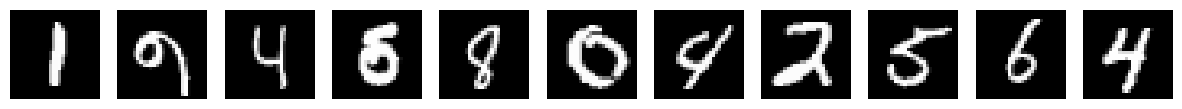

In [7]:
(x_train, y_train), (x_test, y_test), input_shape = load_and_preprocessing(mnist)

raw_examples_plotting(x_train, mnist)

### 1.1. Latent_dim = 2

In [8]:
input_img_2, encoder_2, decoder_2, z_decoded_2, z_mu, z_sigma = VAE(input_shape, latent_dim=2, num_channels=1)

# y is the original image after encoding input img to mu, sigma, z 
# and decoding sampled z values.
y_2 = CustomLayer()([input_img_2, z_decoded_2])


vae_2 = Model(input_img_2, y_2, name='vae')

vae_2.compile(optimizer='adam', loss=None)
vae_2.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)

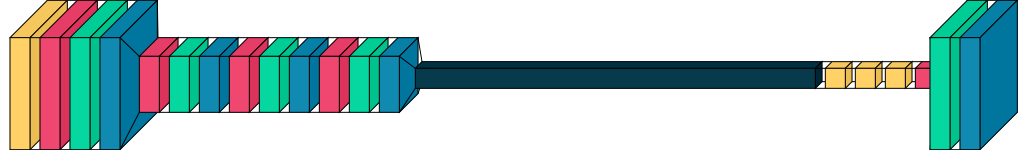

In [13]:
visualkeras.layered_view(vae_2)

In [9]:
history_2 = vae_2.fit(x_train, None, epochs=50, batch_size=32, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50


2024-03-26 14:20:58.043590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-03-26 14:20:58.110944: W tensorflow/c/c_api.cc:305] Operation '{name:'latent_sigma/kernel/Assign' id:354 op device:{requested: '', assigned: ''} def:{{{node latent_sigma/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](latent_sigma/kernel, latent_sigma/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


47968/48000 [============================>.] - ETA: 0s - loss: 0.2274

/home/david/anaconda3/envs/firstenv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-03-26 14:21:45.431354: W tensorflow/c/c_api.cc:305] Operation '{name:'custom_layer/Mean_2' id:582 op device:{requested: '', assigned: ''} def:{{{node custom_layer/Mean_2}} = Mean[T=DT_FLOAT, Tidx=DT_INT32, _has_manual_control_dependencies=true, keep_dims=false](custom_layer/add_4, custom_layer/Const_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


48000/48000 [==============================] - 50s 1ms/sample - loss: 0.2274 - val_loss: 0.2099
Epoch 2/50
48000/48000 [==============================] - 40s 828us/sample - loss: 0.2038 - val_loss: 0.2056
Epoch 3/50
48000/48000 [==============================] - 35s 738us/sample - loss: 0.1963 - val_loss: 0.1970
Epoch 4/50
48000/48000 [==============================] - 36s 756us/sample - loss: 0.1924 - val_loss: 0.1911
Epoch 5/50
48000/48000 [==============================] - 35s 732us/sample - loss: 0.1901 - val_loss: 0.1891
Epoch 6/50
48000/48000 [==============================] - 36s 741us/sample - loss: 0.1884 - val_loss: 0.1884
Epoch 7/50
48000/48000 [==============================] - 34s 711us/sample - loss: 0.1871 - val_loss: 0.1893
Epoch 8/50
48000/48000 [==============================] - 36s 740us/sample - loss: 0.1859 - val_loss: 0.1867
Epoch 9/50
48000/48000 [==============================] - 37s 776us/sample - loss: 0.1851 - val_loss: 0.1864
Epoch 10/50
48000/48000 [=======

In [10]:
vae_2.save('mnist_50e_2ldim.h5')

/home/david/anaconda3/envs/firstenv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/home/david/anaconda3/envs/firstenv/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-03-26 14:56:21.433864: W tensorflow/c/c_api.cc:305] Operation '{name:'latent_mu/BiasAdd' id:341 op device:{requested: '', assigned: ''} def:{{{node latent_mu/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](latent_mu/MatMul, latent_mu/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


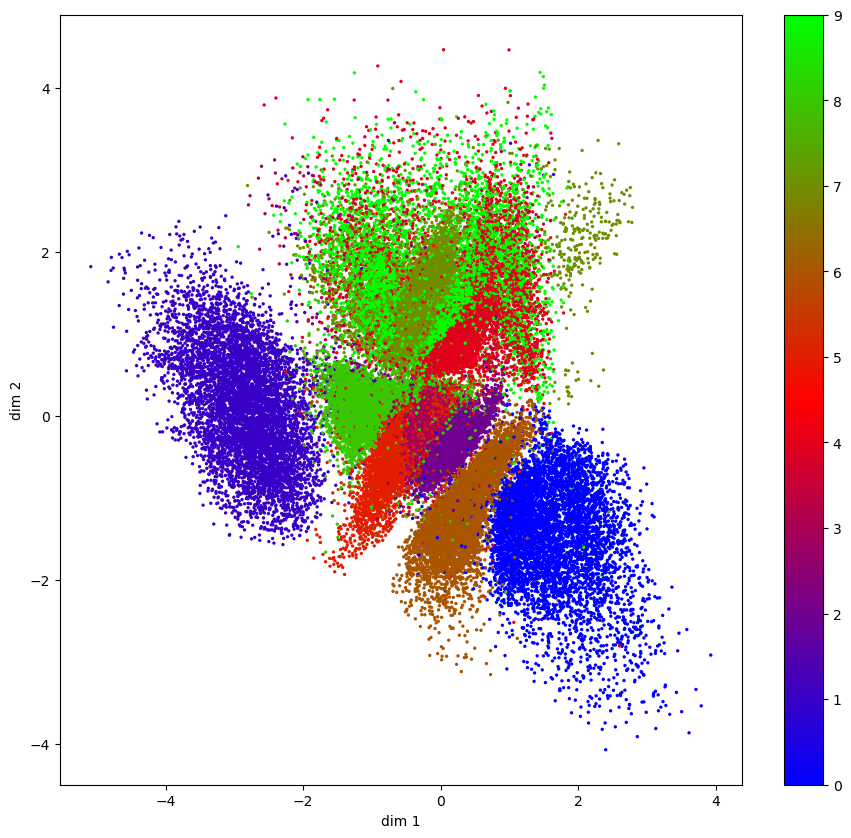

In [11]:
mu_2, _, _ = encoder_2.predict(x_train)

# Vizualize inputs mapped into the LATENT SPACE

plt.figure(figsize=(11, 10))
plt.scatter(mu_2[:, 0], mu_2[:, 1], c=y_train, cmap='brg', s=2)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

2024-03-26 14:57:07.987531: W tensorflow/c/c_api.cc:305] Operation '{name:'decode/Sigmoid' id:492 op device:{requested: '', assigned: ''} def:{{{node decode/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decode/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


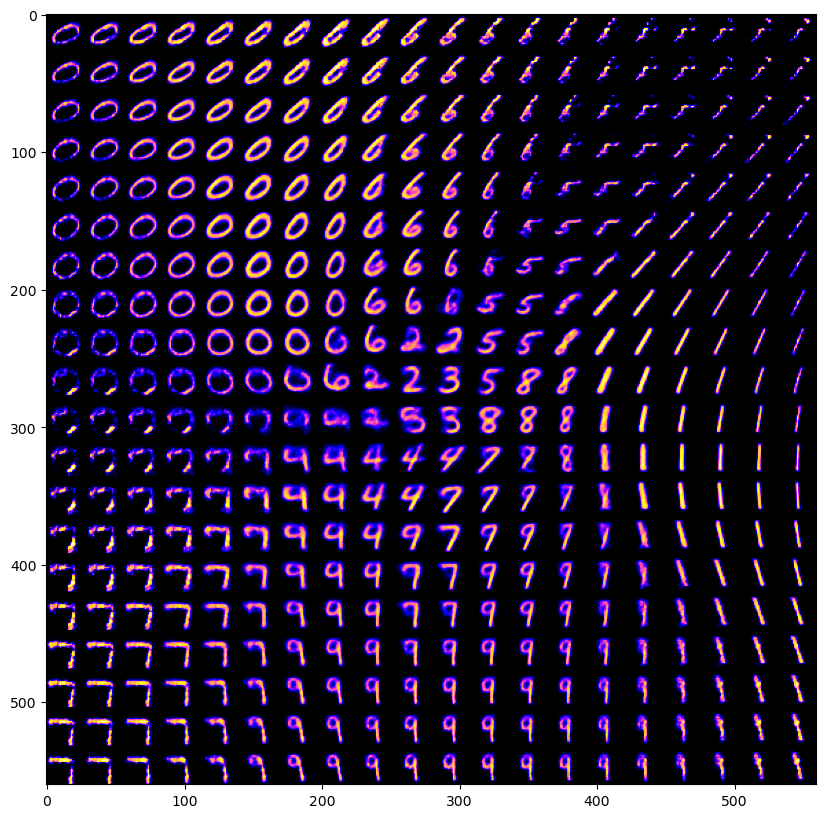

In [12]:
n = 20
figure = np.zeros((input_shape[1] * n, input_shape[0] * n, input_shape[2]))

# Create a grid of latent variables, to be provided as inputs to the decoder

grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_2.predict(z_sample)
        digit = x_decoded[0].reshape(input_shape[1], input_shape[0], input_shape[2])
        figure[i * input_shape[1]: (i + 1) * input_shape[1], j * input_shape[0]: (j + 1) * input_shape[0]] = digit

plt.figure(figsize=(10,10))
# reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()

### 1.2. Latent_dim = 40

In [14]:
input_img_40, encoder_40, decoder_40, z_decoded_40, z_mu, z_sigma = VAE(input_shape, latent_dim=40, num_channels=1)

# y is the original image after encoding input img to mu, sigma, z 
# and decoding sampled z values.
y_40 = CustomLayer()([input_img_40, z_decoded_40])


vae_40 = Model(input_img_40, y_40, name='vae')

vae_40.compile(optimizer='adam', loss=None)
vae_40.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_4 (Bat  (None, 28, 28, 32)           128       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 32)           0         ['batch_normalization_4[0][0

In [14]:
history_40 = vae_40.fit(x_train, None, epochs=50, batch_size=32, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50


2024-03-26 14:57:14.760512: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/batch_normalization_7/gamma/v/Assign' id:2575 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/batch_normalization_7/gamma/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/batch_normalization_7/gamma/v, training_2/Adam/batch_normalization_7/gamma/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


47968/48000 [============================>.] - ETA: 0s - loss: 0.1469

2024-03-26 14:57:52.150786: W tensorflow/c/c_api.cc:305] Operation '{name:'custom_layer_1/Mean_2' id:1996 op device:{requested: '', assigned: ''} def:{{{node custom_layer_1/Mean_2}} = Mean[T=DT_FLOAT, Tidx=DT_INT32, _has_manual_control_dependencies=true, keep_dims=false](custom_layer_1/add_4, custom_layer_1/Const_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


48000/48000 [==============================] - 40s 839us/sample - loss: 0.1469 - val_loss: 0.1286
Epoch 2/50
48000/48000 [==============================] - 38s 786us/sample - loss: 0.1195 - val_loss: 0.1183
Epoch 3/50
48000/48000 [==============================] - 43s 897us/sample - loss: 0.1139 - val_loss: 0.1149
Epoch 4/50
48000/48000 [==============================] - 43s 894us/sample - loss: 0.1108 - val_loss: 0.1114
Epoch 5/50
48000/48000 [==============================] - 44s 925us/sample - loss: 0.1089 - val_loss: 0.1099
Epoch 6/50
48000/48000 [==============================] - 43s 899us/sample - loss: 0.1073 - val_loss: 0.1088
Epoch 7/50
48000/48000 [==============================] - 45s 938us/sample - loss: 0.1061 - val_loss: 0.1073
Epoch 8/50
48000/48000 [==============================] - 43s 905us/sample - loss: 0.1051 - val_loss: 0.1069
Epoch 9/50
48000/48000 [==============================] - 43s 902us/sample - loss: 0.1042 - val_loss: 0.1059
Epoch 10/50
48000/48000 [=====

In [15]:
vae_40.save('mnist_50e_40ldim.h5')

In [16]:
mu_40, _, _ = encoder_40.predict(x_train)

2024-03-26 15:33:36.174918: W tensorflow/c/c_api.cc:305] Operation '{name:'latent_mu_1/BiasAdd' id:1755 op device:{requested: '', assigned: ''} def:{{{node latent_mu_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](latent_mu_1/MatMul, latent_mu_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


### 1.3. Comparison: latent_dim = 2 vs latent_dim = 40

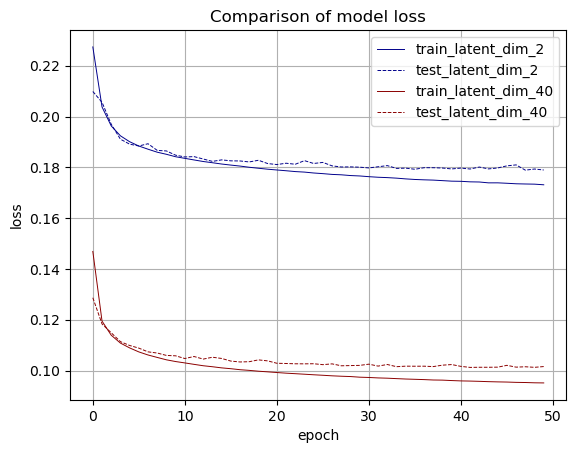

In [30]:
# summarize history for loss
plt.plot(history_2.history['loss'], color='darkblue', linestyle='solid', linewidth=0.7)
plt.plot(history_2.history['val_loss'], color='darkblue', linestyle='dashed', linewidth=0.7)
plt.plot(history_40.history['loss'], color='darkred', linestyle='solid', linewidth=0.7)
plt.plot(history_40.history['val_loss'], color='darkred', linestyle='dashed', linewidth=0.7)
plt.title('Comparison of model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_latent_dim_2', 'test_latent_dim_2', 'train_latent_dim_40', 'test_latent_dim_40'], loc='upper right')
plt.grid('dashed')
plt.show()

In [18]:
samples = []
idx = 0

for y_idx, y in enumerate(y_train):
    if y == idx:
        samples.append(y_idx)
        idx += 1

2024-03-26 15:33:48.518427: W tensorflow/c/c_api.cc:305] Operation '{name:'decode_1/Sigmoid' id:1906 op device:{requested: '', assigned: ''} def:{{{node decode_1/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decode_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


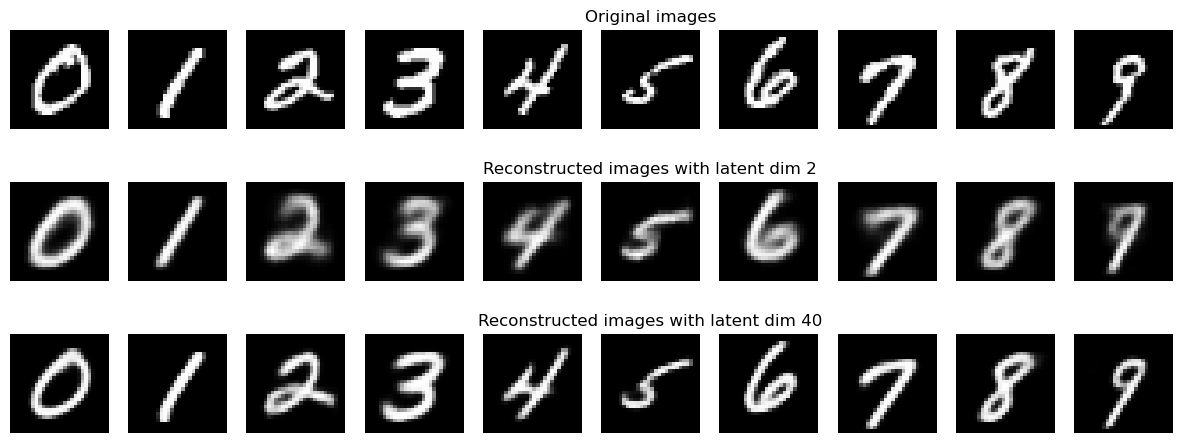

In [19]:
fig, axis = plt.subplots(3, 10, figsize= (15,5.6))
for i, j in enumerate(samples):
    sample_vector_2 = np.array([mu_2[j]])
    sample_vector_40 = np.array([mu_40[j]])    
    decoded_example_2 = decoder_2.predict(sample_vector_2)
    decoded_example_40 = decoder_40.predict(sample_vector_40)
    decoded_reshaped_2 = decoded_example_2.reshape(input_shape[1], input_shape[0])
    decoded_reshaped_40 = decoded_example_40.reshape(input_shape[1], input_shape[0])

    axis[0][i].imshow(x_train[j][:,:,0], cmap='gray')
    axis[0][5].set_title('Original images')
    axis[0][i].axis("off")
    axis[1][i].imshow(decoded_reshaped_2, cmap='gray')
    axis[1][5].set_title('Reconstructed images with latent dim 2')
    axis[1][i].axis("off")
    axis[2][i].imshow(decoded_reshaped_40, cmap='gray')
    axis[2][5].set_title('Reconstructed images with latent dim 40')
    axis[2][i].axis("off")

## 2. CIFAR10 dataset

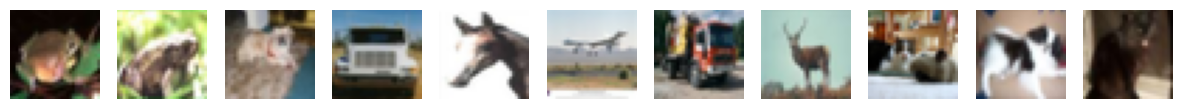

In [20]:
(x_train, y_train), (x_test, y_test), input_shape = load_and_preprocessing(cifar10, num_channels = 3)

raw_examples_plotting(x_train, cifar10)

In [21]:
input_img, encoder, decoder, z_decoded, z_mu, z_sigma = VAE(input_shape, latent_dim=60, num_channels=3)

# y is the original image after encoding input img to mu, sigma, z 
# and decoding sampled z values.
y = CustomLayer()([input_img, z_decoded])


vae = Model(input_img, y, name='vae')

vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 32, 32, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_8 (Bat  (None, 32, 32, 32)           128       ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 32)           0         ['batch_normalization_8[0][0

In [22]:
history = vae.fit(x_train, None, epochs=60, batch_size=32, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/60


2024-03-26 15:33:50.664285: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/conv2d_11/bias/v/Assign' id:3992 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/conv2d_11/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/conv2d_11/bias/v, training_4/Adam/conv2d_11/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


39968/40000 [============================>.] - ETA: 0s - loss: 0.6311

2024-03-26 15:34:34.456965: W tensorflow/c/c_api.cc:305] Operation '{name:'custom_layer_2/Mean_2' id:3418 op device:{requested: '', assigned: ''} def:{{{node custom_layer_2/Mean_2}} = Mean[T=DT_FLOAT, Tidx=DT_INT32, _has_manual_control_dependencies=true, keep_dims=false](custom_layer_2/add_4, custom_layer_2/Const_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


40000/40000 [==============================] - 48s 1ms/sample - loss: 0.6311 - val_loss: 0.6177
Epoch 2/60
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.6144 - val_loss: 0.6080
Epoch 3/60
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.6059 - val_loss: 0.6050
Epoch 4/60
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.6045 - val_loss: 0.6049
Epoch 5/60
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.6033 - val_loss: 0.6040
Epoch 6/60
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.6029 - val_loss: 0.6031
Epoch 7/60
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.6023 - val_loss: 0.6032
Epoch 8/60
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.6020 - val_loss: 0.6029
Epoch 9/60
40000/40000 [==============================] - 47s 1ms/sample - loss: 0.6017 - val_loss: 0.6029
Epoch 10/60
40000/40000 [=======================

In [23]:
vae.save('cifar10_50e_40ldim.h5')

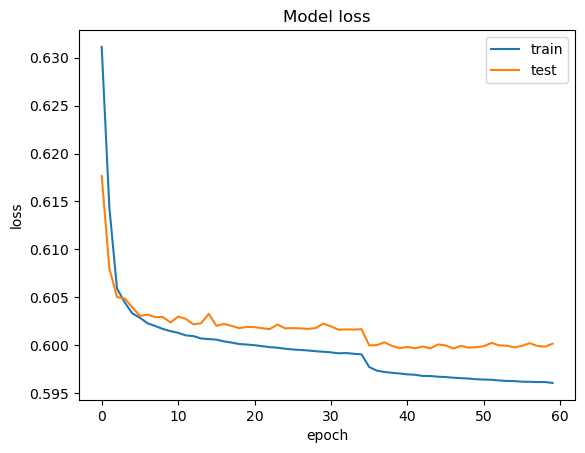

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [25]:
mu, _, _ = encoder.predict(x_train)

2024-03-26 17:26:36.609378: W tensorflow/c/c_api.cc:305] Operation '{name:'latent_mu_2/BiasAdd' id:3177 op device:{requested: '', assigned: ''} def:{{{node latent_mu_2/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](latent_mu_2/MatMul, latent_mu_2/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2024-03-26 17:26:48.701896: W tensorflow/c/c_api.cc:305] Operation '{name:'decode_2/Sigmoid' id:3328 op device:{requested: '', assigned: ''} def:{{{node decode_2/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decode_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


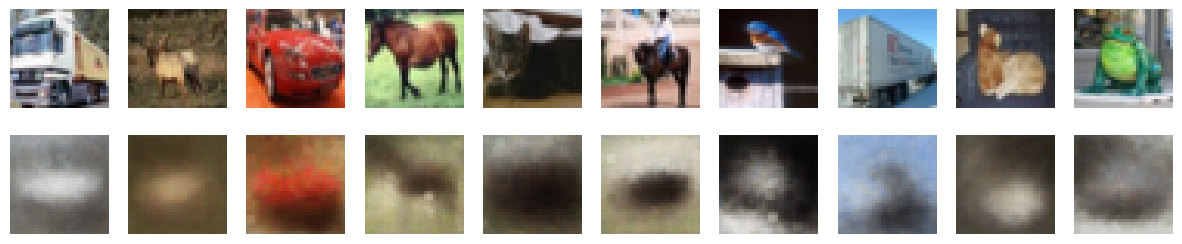

In [26]:
fig, axis = plt.subplots(2, 10, figsize= (15,3))
for i, j in enumerate(samples):
    sample_vector = np.array([mu[j]])     
    decoded_example = decoder.predict(sample_vector)
    decoded_reshaped = decoded_example.reshape(input_shape[1], input_shape[0], input_shape[2])

    axis[0][i].imshow(x_train[j][:,:,:])
    axis[1][i].imshow(decoded_reshaped)     
    axis[0][i].axis("off")
    axis[1][i].axis("off")